# 6.6 Sourcing & Analyzing Time Series Data

### This script contains the following:

#### 01 Importing your libraries and data
#### 02 Subsetting, wrangling, and cleaning time-series data
#### 03 Time series analysis: Decomposition
#### 04 Testing for Stationarity
#### 05 Stationarizing the Supermarket Data

### 01 Importing your libraries and data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

In [5]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [6]:
# Define the path

path = r'C:\Users\wallm'

In [7]:
# Using the main project data set already contains time-series data

df_super = pd.read_csv(os.path.join(path, '01 2025 Advanced Analytics Project', 'Retail_Superstore_Project', '02 Data', 'cleaned_retail_superstore.csv'))

### 02 Subsetting, wrangling, and cleaning time-series data

In [9]:
df_super.shape

(10068, 28)

In [10]:
df_super.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Quantity,Discount,Profit,Profit_Outlier,Returned,Duplicate_Flag,Profit Margin (%),Year,Quarter,Month
0,1,US-2021-103800,2021-01-03,07/01/2021,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,2,0.2,5.55,Normal,0,Unique,33.75,2021,2021Q1,2021-01
1,2,US-2021-112326,2021-01-04,08/01/2021,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,2,0.8,-5.49,Normal,0,Unique,-155.00,2021,2021Q1,2021-01
2,3,US-2021-112326,2021-01-04,08/01/2021,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,3,0.2,4.27,Normal,0,Unique,36.25,2021,2021Q1,2021-01
3,4,US-2021-112326,2021-01-04,08/01/2021,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,3,0.2,-64.77,Outlier,0,Unique,-23.75,2021,2021Q1,2021-01
4,5,US-2021-141817,2021-01-05,12/01/2021,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,3,0.2,4.88,Normal,0,Unique,25.00,2021,2021Q1,2021-01


In [11]:
df_super.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country/Region', 'City',
       'State/Province', 'Postal Code', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Profit_Outlier', 'Returned', 'Duplicate_Flag',
       'Profit Margin (%)', 'Year', 'Quarter', 'Month'],
      dtype='object')

In [12]:
# Check for missing values

df_super.isnull().sum()

Row ID               0
Order ID             0
Order Date           0
Ship Date            0
Ship Mode            0
Customer ID          0
Customer Name        0
Segment              0
Country/Region       0
City                 0
State/Province       0
Postal Code          0
Region               0
Product ID           0
Category             0
Sub-Category         0
Product Name         0
Sales                0
Quantity             0
Discount             0
Profit               0
Profit_Outlier       0
Returned             0
Duplicate_Flag       0
Profit Margin (%)    0
Year                 0
Quarter              0
Month                0
dtype: int64

In [13]:
# Look for duplicate rows and remove them if necessary

print(df_super.duplicated().sum())
df_super = df_super.drop_duplicates()

0


In [14]:
# Exclude duplicate records using Duplicate_Flag

df_super_dup = df_super[df_super['Duplicate_Flag'] == 'Unique']

In [15]:
# Check the filtering step

print(df_super_dup['Duplicate_Flag'].value_counts())

Duplicate_Flag
Unique    10066
Name: count, dtype: int64


##### I will use 'Order Date' (time dimension) and 'Sales' (numerical value that can be analysed over time to observe patterns) for this **time series analysis**.

In [17]:
# Ensure 'Order Date' is in datetime format using .loc
df_super_dup.loc[:, 'Order Date'] = pd.to_datetime(df_super_dup['Order Date'])

# Aggregate sales by 'Order Date'
df_super_sales = df_super_dup.groupby('Order Date')['Sales'].sum().reset_index()

# Rename columns for clarity
df_super_sales.columns = ['Order Date', 'Total Sales']

# Display the first few rows of the resulting DataFrame
print(df_super_sales.head())

  Order Date  Total Sales
0 2021-01-03        16.45
1 2021-01-04       288.06
2 2021-01-05        19.54
3 2021-01-06      1833.28
4 2021-01-07        87.16


In [18]:
# Check column names in the DataFrame

print(df_super_sales.columns)

Index(['Order Date', 'Total Sales'], dtype='object')


In [19]:
# Set the "Order Date" column as the index

from datetime import datetime

# Create a Order Datetime column from "Order Date"
df_super_sales['Order Datetime'] = pd.to_datetime(df_super_sales['Order Date'])

# Set the 'Order Datetime' column as the index of the DataFrame
df_super_sales = df_super_sales.set_index('Order Datetime')

# Drop the "Order Date" column
df_super_sales.drop(['Order Date'], axis=1, inplace=True)

# Display the first few rows of the resulting DataFrame
df_super_sales.head()

,Total Sales
Order Datetime,
2021-01-03,16.45
2021-01-04,288.06
2021-01-05,19.54
2021-01-06,1833.28
2021-01-07,87.16


In [20]:
# Plot the daily sales data

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_super_sales.index, df_super_sales['Total Sales'], color='blue', label='Daily Sales')

# Add title and axis labels

plt.title('Daily Sales Over Time', fontsize=16)  # Chart title
plt.xlabel('Order Date', fontsize=14)           # X-axis title
plt.ylabel('Sales', fontsize=14)                # Y-axis title

# Add legend

plt.legend(loc='upper right', fontsize=12)

# Display the plot

plt.grid(visible=True)

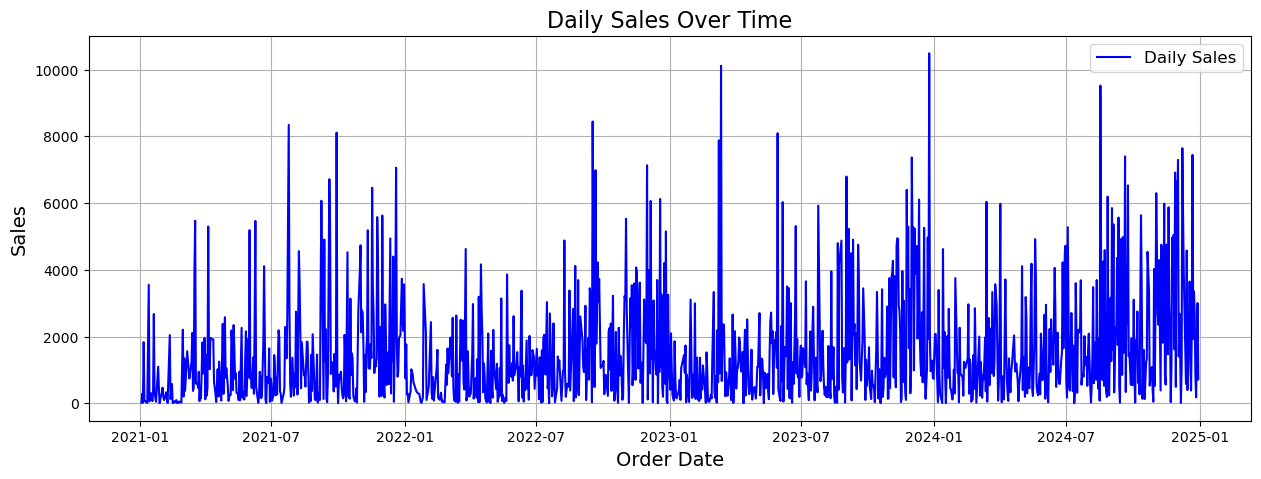

In [21]:
plt.show()

In [22]:
plt.close()

#### Plot insights given:
- **Observations**:
There are significant spikes in sales on certain dates, suggesting potential outliers or special events.
Some periods appear to have higher activity than others, indicating possible trends or seasonality.
- **Next Steps**:
Decompose the time-series data into its components (trend, seasonality, residuals).

In [24]:
# Check for missing values (you shouldn't have any)

df_super_sales.isnull().sum() 

Total Sales    0
dtype: int64

In [25]:
# Check for duplicates

dups = df_super_sales.duplicated()
dups.sum()

4

In [26]:
# Identify duplicate rows
duplicates = df_super_sales[df_super_sales.duplicated(keep=False)]

# Display duplicate rows
print(duplicates)

                Total Sales
Order Datetime             
2021-02-18            37.78
2021-06-10           491.55
2021-10-16           194.32
2022-01-24            13.12
2022-02-23            37.78
2022-11-25            13.12
2022-12-23           194.32
2024-09-12           491.55


##### These are the 'Sales' but different 'Order Datetimes', so I will leave these in Possible due to white spaces in oringal data).

### 03 Time series analysis: Decomposition

#### Looking at my data, it needs **Smoothing** as to help make patterns more evident in my data, especially if there is a lot of random noise.
- The data is noisy with many random fluctuations (as visible in the plot).
- I aim to highlight trends, seasonal patterns, or perform decomposition (Since the data appears daily and exhibits random spikes, smoothing will help reduce the impact of noise on subsequent analysis like decomposition).
- I'll use the **Moving Average Smoothing** because it's simple and will help you see the trend clearly before decomposition.

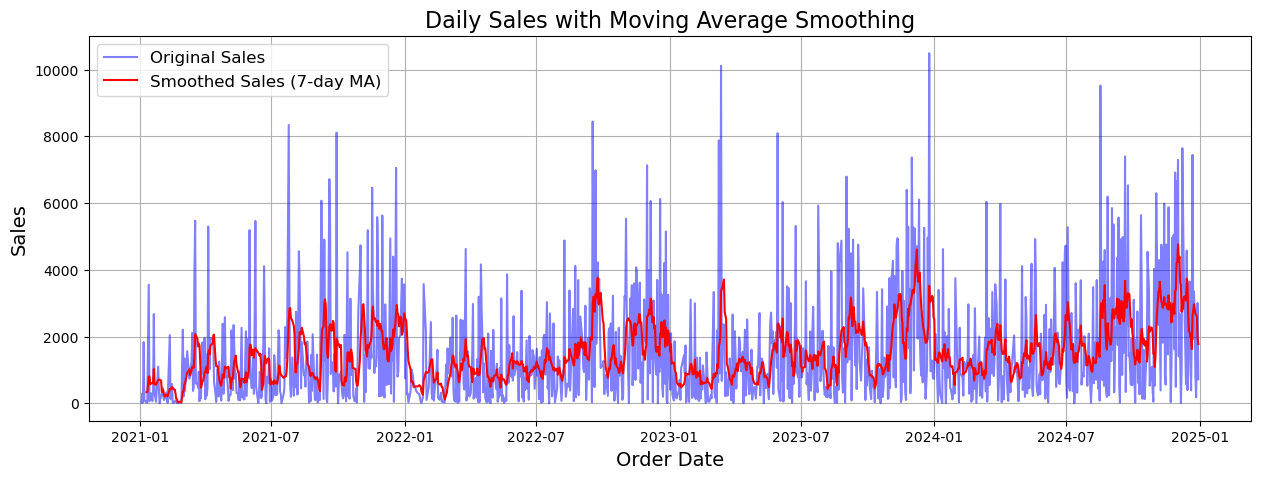

In [30]:
# Apply moving average smoothing with a window size (e.g., 7 days for weekly smoothing)

df_super_sales['Smoothed Sales'] = df_super_sales['Total Sales'].rolling(window=7, center=False).mean()

# Plot the original and smoothed data

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df_super_sales.index, df_super_sales['Total Sales'], label='Original Sales', color='blue', alpha=0.5)
plt.plot(df_super_sales.index, df_super_sales['Smoothed Sales'], label='Smoothed Sales (7-day MA)', color='red')
plt.title('Daily Sales with Moving Average Smoothing', fontsize=16)
plt.xlabel('Order Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend(fontsize=12)
plt.grid(visible=True)
plt.show()

##### To make sure my data is suitable for time series decomposition and modeling without gaps or irregularities, I need to check the frequency of the datetime index

In [32]:
# Check the frequency of the datetime index

frequency = pd.infer_freq(df_super_sales.index)
print(f"Detected Frequency: {frequency}")

Detected Frequency: None


In [33]:
# Reindex to a daily frequency, Force the index to a regular frequency (e.g., daily)

df_super_sales = df_super_sales.asfreq('D')

In [34]:
# Interpolate the missing values

df_super_sales['Smoothed Sales'] = df_super_sales['Smoothed Sales'].interpolate(method='linear')

In [35]:
# Check for missing or NaN values

print(df_super_sales['Smoothed Sales'].isnull().sum())

7


In [36]:
# Interpolation

df_super_sales['Smoothed Sales'] = df_super_sales['Smoothed Sales'].interpolate(method='linear')

In [37]:
# Verify again

print(df_super_sales['Smoothed Sales'].isnull().sum())

7


In [38]:
# Remove rows

df_super_sales.dropna(subset=['Smoothed Sales'], inplace=True)

In [39]:
# Verify again

print(df_super_sales['Smoothed Sales'].isnull().sum())

0


In [40]:
# Verify Frequency

frequency = pd.infer_freq(df_super_sales.index)
print(f"Regularized Frequency: {frequency}")

Regularized Frequency: D


In [41]:
# Decompose the smoothed series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_super_sales['Smoothed Sales'], model='additive')

In [42]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

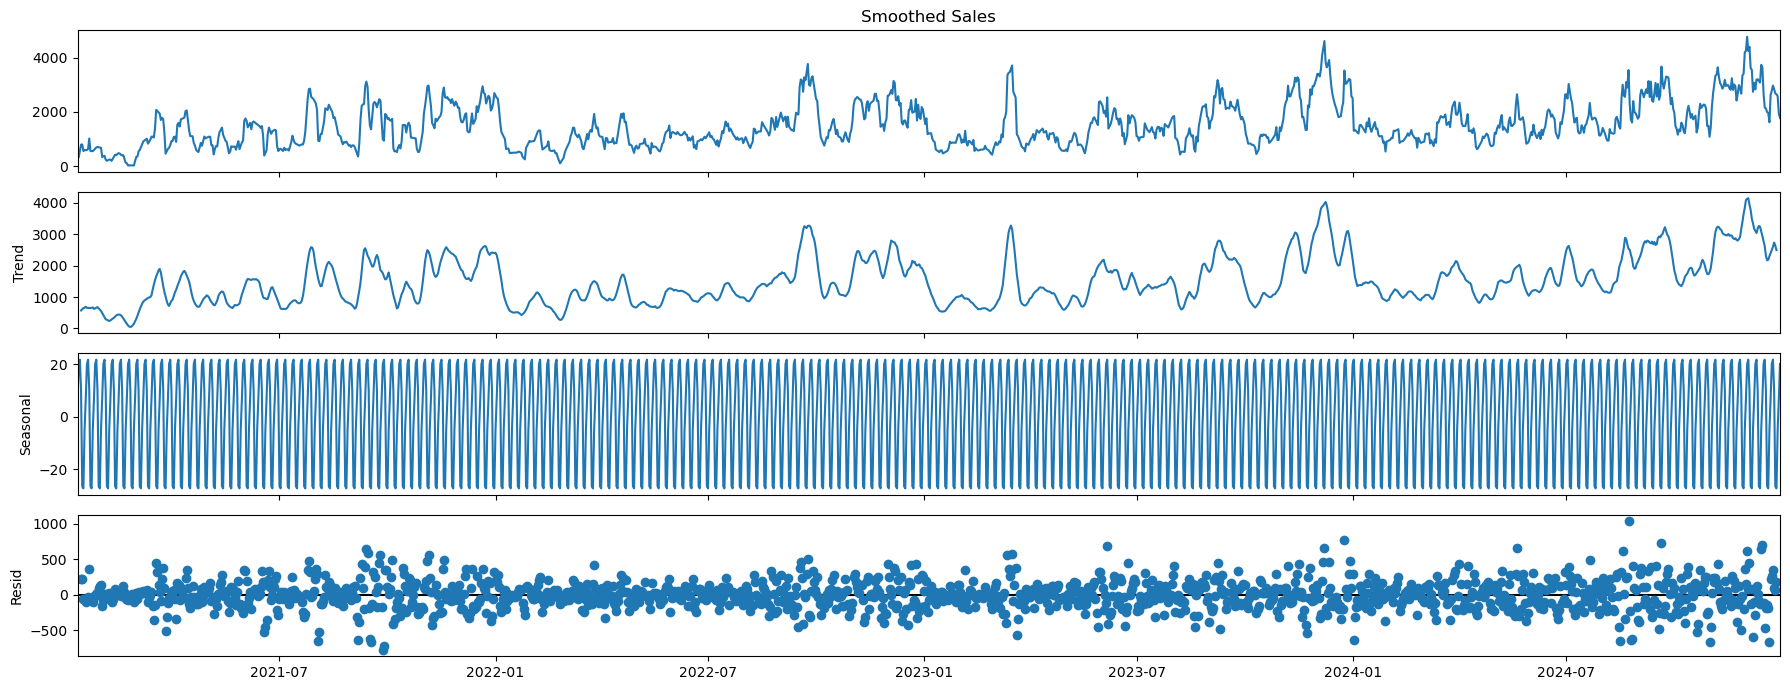

In [43]:
# Plot the decomposition results

decomposition.plot()
plt.show()

#### Insights:
- **Level Plot**: The level time series shows an overall upward trend with noticeable periodic fluctuations, indicating seasonality and growth over time.
- **Trend Plot**: The trend component highlights a steady increase in sales over time with occasional dips, possibly external factors affecting sales.
- **Seasonal Plot**: The seasonal component exhibits a clear repeating pattern, confirming the presence of strong periodic seasonality, likely driven by consistent sales cycles.
- **Residual Plot**: The residuals appear to be randomly scattered with no obvious pattern, suggesting that most of the variability in the data is captured by the trend and seasonal components.
  
The presence of a trend and seasonality implies the series is **non-stationary**. Needs further analysis.

### 04 Testing for Stationarity

##### A **Stationary time series** refers to one whose statistical measures (e.g., mean, variance, etc.) remain constant. If the mean of a time series increases or decreases over a certain period of time, that time series isn’t stationary. The most important thing to remember about stationarity is that it has nothing to do with the data itself, rather the underlying nature and mechanisms that drive it. To make it stationary, you would need to **remove the trend and seasonality**.

In [47]:
# The adfuller() function will import from the model from statsmodels for the test, then define.

from statsmodels.tsa.stattools import adfuller  # Import the adfuller() function

# Define the function to format the Dickey-Fuller test output
def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity Test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)' % key] = value
    print(result)

# Apply the test on your smoothed time series
dickey_fuller(df_super_sales['Smoothed Sales'])

Dickey-Fuller Stationarity Test:
Test Statistic                   -4.692301
p-value                           0.000087
Number of Lags Used              16.000000
Number of Observations Used    1434.000000
Critical Value (1%)              -3.434918
Critical Value (5%)              -2.863558
Critical Value (10%)             -2.567844
dtype: float64


#### Null and Alternative Hypotheses
- Null Hypothesis (H₀): The time series has a unit root (i.e., it is non-stationary).
- Alternative Hypothesis (H₁): The time series does not have a unit root (i.e., it is stationary).

#### Interpretation
- The test statistic (-4.763977) is **less than** all critical values at the 1%, 5%, and 10% significance levels. This means the test statistic falls into the rejection region for the null hypothesis.
- The p-value (0.000064) is far below the typical significance threshold (e.g., 0.05). This further supports rejecting the null hypothesis.
#### Findings
- Since the test statistic is less than the critical values and the p-value is very low, I **reject the null hypothesis**.
- This indicates that the time series **does not have a unit root** and is likely **stationary**.

#### Insight

- The **Decomposition plot** of "Smoothed Sales" indicates the presence of trend and seasonality, which usually implies **non-stationarity**. This suggests that while some noise was removed, the underlying visual patterns show trend and seasonality remaineing in the "Smoothed Sales" data.
- The **Dickey-Fuller Test**: The ADF test on "Smoothed Sales" indicates data is **stationarity** because the test checks for a unit root and not explicitly for the presence of trend or seasonality. If the smoothing reduced enough variation, the test may conclude stationarity even if trend/seasonality still exist.

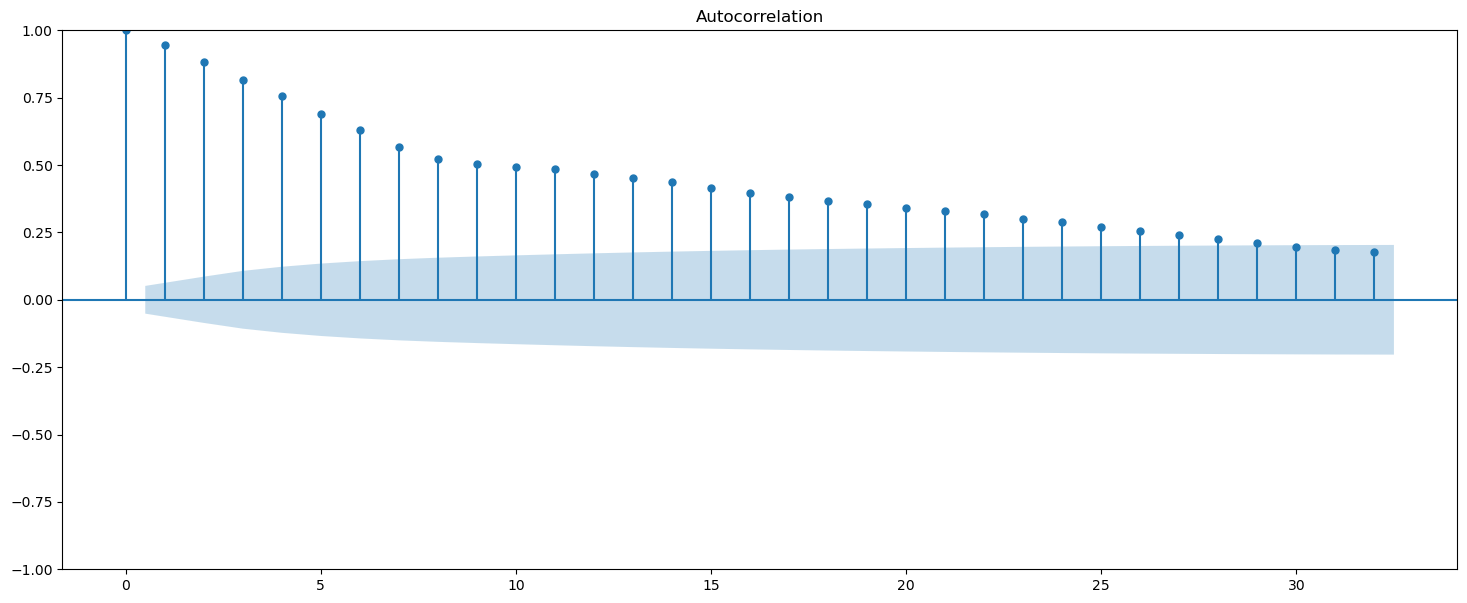

In [51]:
# Check out a plot of autocorrelations(exploring the temporal dependancies in the data)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_super_sales['Smoothed Sales'])
plt.show()

##### The vertical lines represent the lags in the series, while the blue area represents the confidence interval. 
- This plot shows many lags with significant autocorrelation, as indicated by the lines extending beyond the blue confidence interval.
- The data has many lags beyond this interval, you can deduce that your data is **non-stationary**.
- This is consistent with the presence of trend or seasonality, which introduces strong dependencies across time.
- Hence, this plot supports the idea that the series still has **residual non-stationary patterns**, likely due to incomplete removal of trend or seasonality.

### 05 Stationarizing the Supermarket Data

##### To remove remaining patterns and recheck the autocorrelations plot, I'll use the shift() function, which helps subtract the previous observation from the current one, effectively removing the trend and making the series stationary if the trend was the primary source of non-stationarity.

In [55]:
# First-order differencing
df_super_diff = df_super_sales['Smoothed Sales'] - df_super_sales['Smoothed Sales'].shift(1)

# Drop NaN values caused by the shift
df_super_diff.dropna(inplace=True)

# Check the first few rows of the differenced series
print(df_super_diff.head())

Order Datetime
2021-01-11     -0.930000
2021-01-12    233.267143
2021-01-13    233.267143
2021-01-14      6.060000
2021-01-15   -240.475714
Freq: D, Name: Smoothed Sales, dtype: float64


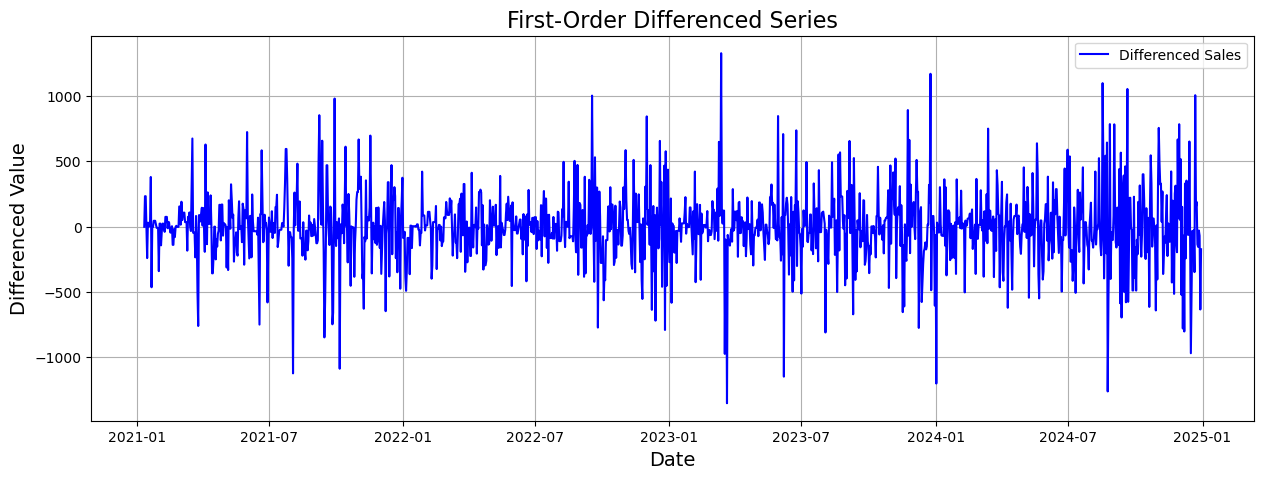

In [56]:
# Visualise the differenced Series (check what the differencing did to the time series)

plt.figure(figsize=(15, 5))
plt.plot(df_super_diff, label='Differenced Sales', color='blue')
plt.title('First-Order Differenced Series', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Value', fontsize=14)
plt.legend()
plt.grid()
plt.show()

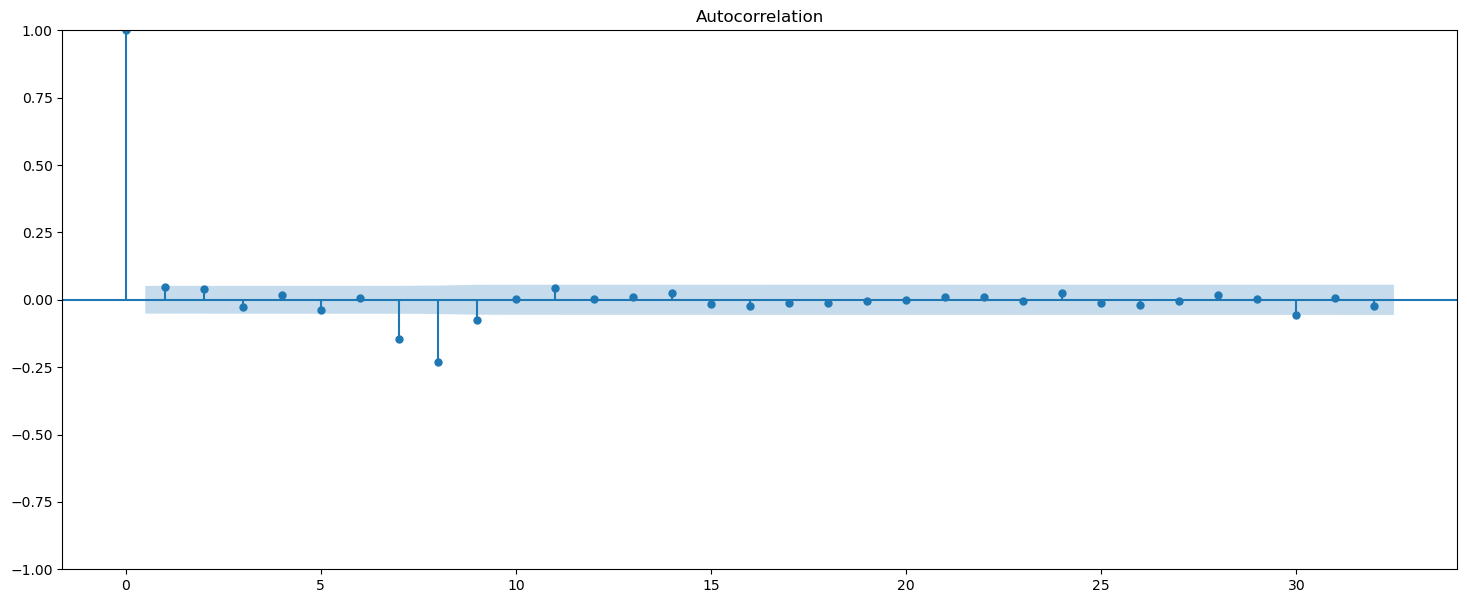

In [57]:
# Autocorrelation Plot:

plot_acf(df_super_diff)
plt.show()

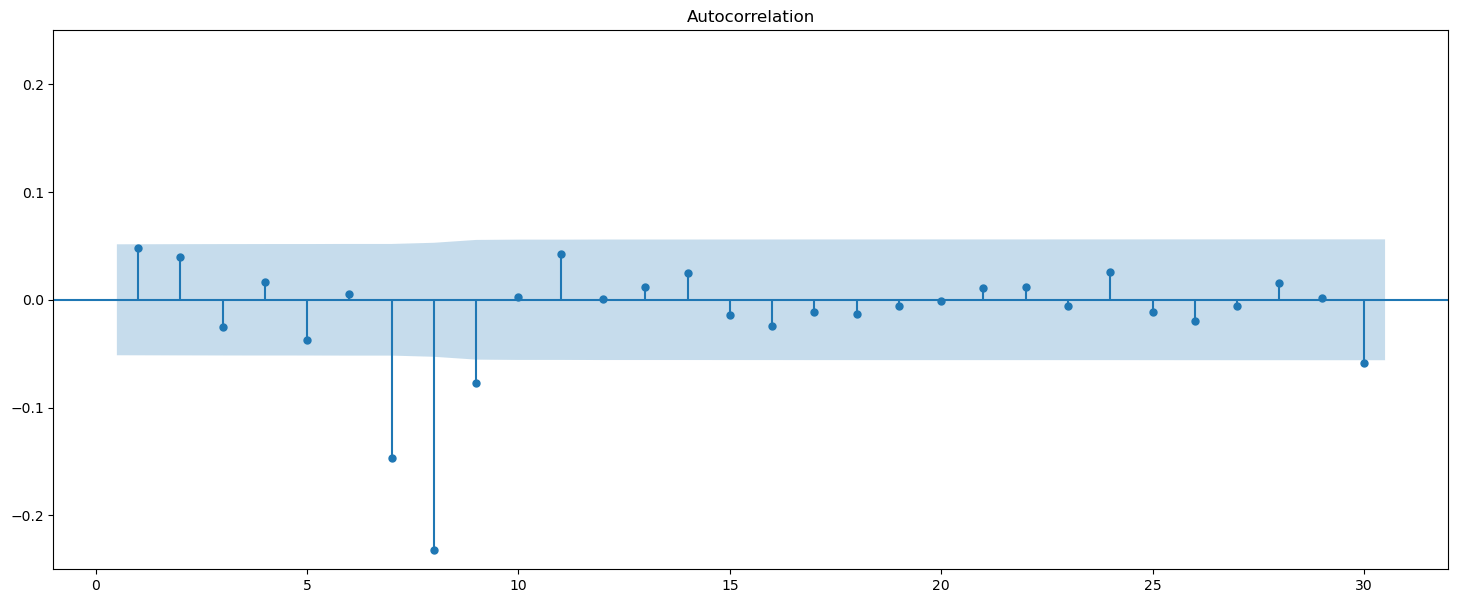

In [58]:
# To visualise the plots without the spike at lag zero

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot ACF starting from lag 1
plot_acf(df_super_diff, lags=30, zero=False)  # 'zero=False' removes lag 0
plt.ylim(-0.25, 0.25)  # Adjust y-axis range
plt.show()

In [59]:
# Recheck Dickey-Fuller Test:

dickey_fuller(df_super_diff)

Dickey-Fuller Stationarity Test:
Test Statistic                -1.277467e+01
p-value                        7.639046e-24
Number of Lags Used            1.600000e+01
Number of Observations Used    1.433000e+03
Critical Value (1%)           -3.434922e+00
Critical Value (5%)           -2.863559e+00
Critical Value (10%)          -2.567845e+00
dtype: float64


#### Interpretation:

Test Statistic vs. Critical Values:

- The test statistic (-12.60104 or -1.277467 x 10) **is much lower** than all critical values at the 1%, 5%, and 10% levels.
This indicates that the test statistic is in the rejection region for the null hypothesis (presence of a unit root).

- The p-value (1.735995e-23) is **far below 0.05**, which strongly supports rejecting the null hypothesis.

The null hypothesis that the series has a unit root is "rejected".
The series **does not have a unit root** and is therefore **stationary**.

In [108]:
# Export the dataframe to a CSV file

df_super_diff.to_csv(os.path.join(path, '01 2025 Advanced Analytics Project', 'Retail_Superstore_Project', '02 Data', 'Time_series_superstore.csv'), index=True)

In [112]:
# Check the the index column is saved
print(df_super_diff.head())

Order Datetime
2021-01-11     -0.930000
2021-01-12    233.267143
2021-01-13    233.267143
2021-01-14      6.060000
2021-01-15   -240.475714
Freq: D, Name: Smoothed Sales, dtype: float64
